In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = "/content/gdrive/My Drive/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pathlib
#Root directory for dataset
dataroot = "/content/gdrive/My Drive/Car_data/"
data_dir = pathlib.Path(dataroot)

In [ ]:
train_dir = os.path.join(data_dir, 'Train')
validation_dir = os.path.join(data_dir, 'Test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1700 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 370 files belonging to 2 classes.


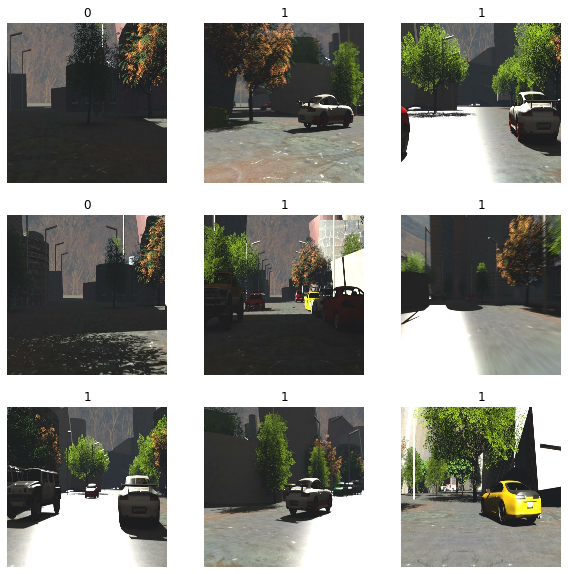

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 10
Number of test batches: 2


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.6),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=.5, width_factor=.5,fill_mode='reflect')
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


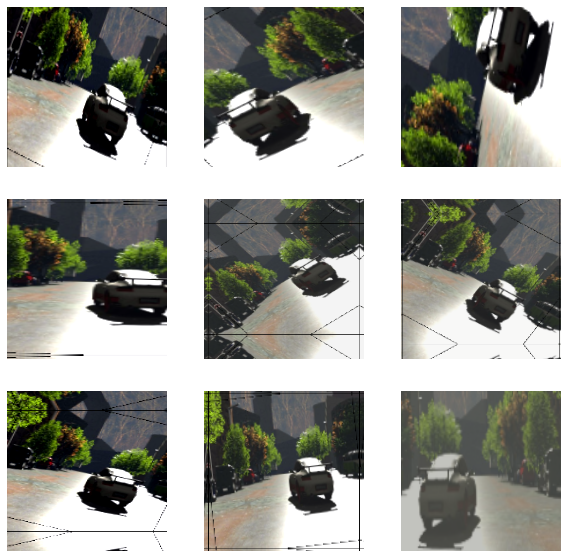

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_2 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

10/10 [==============================] - 1s 52ms/step - loss: 1.2430 - accuracy: 0.5033


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.24
initial accuracy: 0.50


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
54/54 [==============================] - 9s 158ms/step - loss: 0.9089 - accuracy: 0.5029 - val_loss: 0.6426 - val_accuracy: 0.6307
Epoch 2/10
54/54 [==============================] - 8s 157ms/step - loss: 0.7085 - accuracy: 0.6012 - val_loss: 0.5553 - val_accuracy: 0.6863
Epoch 3/10
54/54 [==============================] - 8s 157ms/step - loss: 0.5996 - accuracy: 0.6812 - val_loss: 0.5342 - val_accuracy: 0.6863
Epoch 4/10
54/54 [==============================] - 8s 157ms/step - loss: 0.5337 - accuracy: 0.7212 - val_loss: 0.5073 - val_accuracy: 0.7222
Epoch 5/10
54/54 [==============================] - 9s 160ms/step - loss: 0.4857 - accuracy: 0.7512 - val_loss: 0.4816 - val_accuracy: 0.7320
Epoch 6/10
54/54 [==============================] - 9s 159ms/step - loss: 0.4465 - accuracy: 0.7829 - val_loss: 0.5052 - val_accuracy: 0.7255
Epoch 7/10
54/54 [==============================] - 8s 157ms/step - loss: 0.4191 - accuracy: 0.8012 - val_loss: 0.4685 - val_accuracy: 0.7549
Epoch 

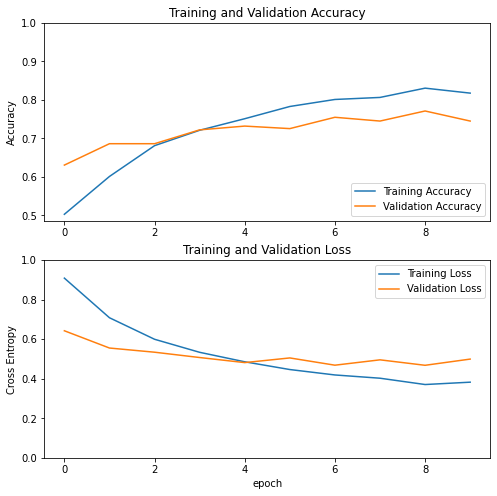

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 90

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_2 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)             

In [ ]:
len(model.trainable_variables)

104

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
54/54 [==============================] - 11s 195ms/step - loss: 0.2722 - accuracy: 0.8853 - val_loss: 0.4947 - val_accuracy: 0.8137
Epoch 11/20
54/54 [==============================] - 10s 179ms/step - loss: 0.1581 - accuracy: 0.9376 - val_loss: 0.6969 - val_accuracy: 0.8562
Epoch 12/20
54/54 [==============================] - 10s 179ms/step - loss: 0.1335 - accuracy: 0.9465 - val_loss: 0.6416 - val_accuracy: 0.8627
Epoch 13/20
54/54 [==============================] - 10s 179ms/step - loss: 0.1060 - accuracy: 0.9588 - val_loss: 0.8114 - val_accuracy: 0.8431
Epoch 14/20
54/54 [==============================] - 10s 176ms/step - loss: 0.0892 - accuracy: 0.9665 - val_loss: 0.9170 - val_accuracy: 0.8529
Epoch 15/20
54/54 [==============================] - 10s 176ms/step - loss: 0.0890 - accuracy: 0.9706 - val_loss: 0.7384 - val_accuracy: 0.8072
Epoch 16/20
54/54 [==============================] - 10s 181ms/step - loss: 0.0772 - accuracy: 0.9729 - val_loss: 0.7511 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

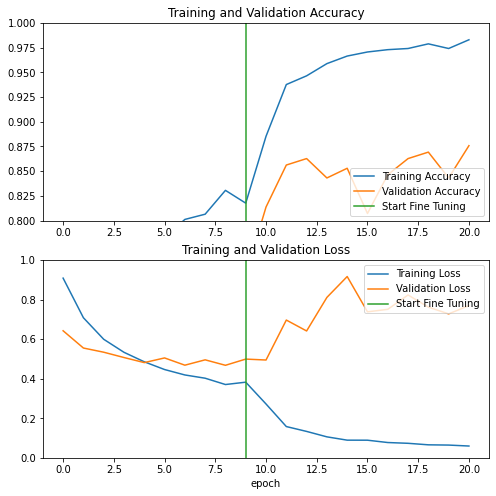

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Save Model

In [ ]:
model.save('/content/gdrive/My Drive/Car_data/Model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Car_data/Model/assets


Evalutaion and prediction

In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/My Drive/Car_data/Model')

In [ ]:
new_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_2  (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_BiasAdd_2 (Tenso (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)             

Evaluation and prediction

In [ ]:
loss, accuracy = new_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 0s 67ms/step - loss: 1.2633 - accuracy: 0.8125
Test accuracy : 0.8125


Predictions:
 [0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0]
Labels:
 [0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1]


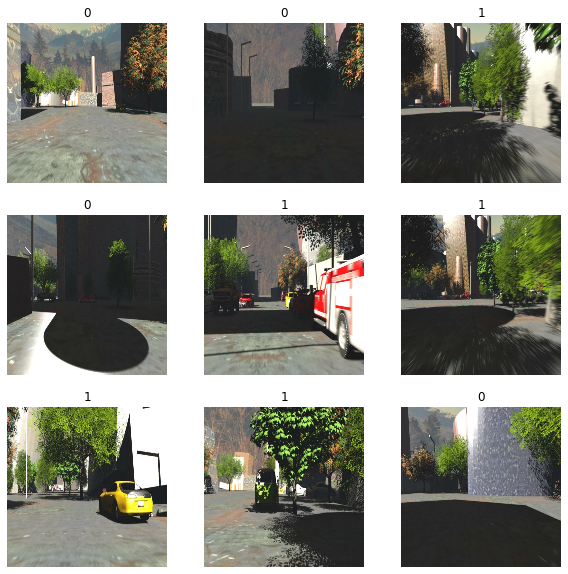

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = new_model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")